# **Sentimen Analysis Review BCAmobile Apps**

Proyek Sentimen Analisis Review Aplikasi BCA Mobile bertujuan untuk menganalisis ulasan pengguna aplikasi BCA Mobile di Google Play Store guna memahami sentimen yang ada, apakah positif, negatif, atau netral. Dengan menggunakan teknik pemrosesan bahasa alami (NLP) dan model machine learning, kita akan mengidentifikasi pola sentimen dalam ulasan yang diberikan oleh pengguna aplikasi ini.

Proyek ini akan dimulai dengan mengumpulkan data ulasan pengguna menggunakan Google Play Scraper, dilanjutkan dengan pemrosesan data dan analisis sentimen menggunakan pustaka Python seperti NLTK, scikit-learn, dan TensorFlow. Hasil analisis ini akan memberikan wawasan yang berguna bagi pengembang aplikasi BCA Mobile untuk meningkatkan kualitas dan pengalaman pengguna berdasarkan feedback yang diterima.

# **0. Import Library**

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
import nltk
import requests
import csv

from io import StringIO

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
!pip freeze > requirements.txt

# **1. Load Dataset**

## **1.1 Dataset Preview**

In [8]:
dataset = pd.read_csv('/content/ulasan_BCAmobile.csv')
df_reviews= pd.DataFrame(dataset)
df_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,5adb3e71-2577-4f04-a220-3451de82d7d1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"u/ versi 4.62 Di menu transfer sesama Bank, un...",4,8,4.6.2,2025-04-20 03:07:19,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-20 03:09:47,4.6.2
1,c14a1950-d6c7-4fbf-a652-5467d8b31a19,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya beralih dari myBCA ke aplikasi BCA mobile...,2,2,4.6.3,2025-04-21 09:08:18,Mohon maaf atas ketidaknyamanannya. Saran dan ...,2025-04-21 09:21:54,4.6.3
2,b5e7c8f8-ee5c-4716-994b-cd4665309edb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"parah nih aplikasi, setelah update untuk menu ...",1,72,4.6.2,2025-04-18 12:00:59,Mohon maaf atas ketidaknyamanan yang Bapak/Ibu...,2025-04-18 12:13:27,4.6.2
3,9e4acabb-824d-4e77-a1cc-480882b994a8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saat mau transfer, nama tujuan rekening tidak ...",5,81,4.6.3,2025-04-21 07:23:24,"Mohon maaf atas ketidaknyamanannya, saat ini s...",2025-04-21 07:32:36,4.6.3
4,bf905aaf-d767-4c59-a610-ebe2d445097e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi bagus dan interfacenya sederhana sehi...,5,4,4.6.3,2025-04-22 03:12:57,Mohon maaf atas ketidaknyamanannya. Saran dan ...,2025-04-22 04:15:27,4.6.3


In [9]:
df_reviews.shape

(112500, 11)

## **1.2 Check Dataset Info**

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112500 entries, 0 to 112499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              112500 non-null  object
 1   userName              112500 non-null  object
 2   userImage             112500 non-null  object
 3   content               112500 non-null  object
 4   score                 112500 non-null  int64 
 5   thumbsUpCount         112500 non-null  int64 
 6   reviewCreatedVersion  92389 non-null   object
 7   at                    112500 non-null  object
 8   replyContent          107699 non-null  object
 9   repliedAt             107699 non-null  object
 10  appVersion            92389 non-null   object
dtypes: int64(2), object(9)
memory usage: 9.4+ MB


**Note**:
- Dataset cukup banyak missing value, hal ini terjadi saat proses scraping data.

In [11]:
# recheck tipe data
data_desc = (
    df_reviews
    .columns
    .to_series()
    .groupby(df_reviews.dtypes)
    .groups.items()
)

for dtype, columns in data_desc:
    print(f"{dtype}:")
    for col in columns:
        print(f"  - {col}")

int64:
  - score
  - thumbsUpCount
object:
  - reviewId
  - userName
  - userImage
  - content
  - reviewCreatedVersion
  - at
  - replyContent
  - repliedAt
  - appVersion


**Note**:
- Fitur 'at' dan 'repliedAt' memiliki tipe data object yang mestinya datetime. Sehingga dirubah ke tipe data semestinya.

In [12]:
df_reviews['at'] = pd.to_datetime(df_reviews['at'])
df_reviews['repliedAt'] = pd.to_datetime(df_reviews['repliedAt'])

In [13]:
data_desc = (
    df_reviews
    .columns
    .to_series()
    .groupby(df_reviews.dtypes)
    .groups.items()
)

for dtype, columns in data_desc:
    print(f"{dtype}:")
    for col in columns:
        print(f"  - {col}")

int64:
  - score
  - thumbsUpCount
datetime64[ns]:
  - at
  - repliedAt
object:
  - reviewId
  - userName
  - userImage
  - content
  - reviewCreatedVersion
  - replyContent
  - appVersion


## **1.3 Check Missing Value**

In [14]:
# check missing values
df_reviews.isna().any()

,0
reviewId,False
userName,False
userImage,False
content,False
score,False
thumbsUpCount,False
reviewCreatedVersion,True
at,False
replyContent,True
repliedAt,True


In [15]:
df_reviews.isna().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,20111
at,0
replyContent,4801
repliedAt,4801


**Note**:
- Jumlah missing value masih dalam toleransi sehingga nilai yang kosong bisa di drop saja.

In [16]:
df_reviews.dropna(inplace=True)
df_reviews.isna().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,0
at,0
replyContent,0
repliedAt,0


## **1.4 Check Duplicated**

In [17]:
df_reviews.duplicated().sum()

np.int64(0)

# **2. Preprocessing**

## **2.1 Clean Text**

In [18]:
df_pre = df_reviews.copy()

In [19]:
def cleaningText(text):
    text = re.sub(r"http\S+", '', text)  # menghapus link
    text = re.sub(r'[0-9]+', '', text)  # menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ')  # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # menghapus semua tanda baca
    text = text.strip(' ')  # menghapus karakter spasi dari kiri dan kanan teks
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # menghapus emoji dan karakter non-ASCII
    return text

In [20]:
df_pre['text_clean'] = df_pre['content'].apply(cleaningText)

## **2.2 Casefolding Text**

In [21]:
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

In [22]:
df_pre['text_casefoldingText'] = df_pre['text_clean'].apply(casefoldingText)

## **2.3 Slangwords**

In [23]:
slangwords = {
    "@": "di",
    "7an": "tujuan",
    "ababil": "abg labil",
    "acc": "accord",
    "ad": "ada",
    "adlah": "adalah",
    "adoh": "aduh",
    "afaik": "as far as i know",
    "aha": "tertawa",
    "ahaha": "haha",
    "ahokncc": "ahok",
    "aing": "saya",
    "aja": "saja",
    "ajep-ajep": "dunia gemerlap",
    "ajj": "saja",
    "ak": "saya",
    "aka": "dikenal juga sebagai",
    "akika": "aku",
    "akkoh": "aku",
    "akko": "aku",
    "akku": "aku",
    "akuwh": "aku",
    "akyu": "aku",
    "alay": "norak",
    "aljasa": "asal jadi saja",
    "alow": "halo",
    "ama": "sama",
    "ambilin": "ambilkan",
    "ambl": "ambil",
    "ampun": "maaf",
    "analisise": "analisis",
    "ancur": "hancur",
    "ank": "anak",
    "anjir": "anjing",
    "anjrit": "anjing",
    "anter": "antar",
    "ap": "apa",
    "ap2": "apa-apa",
    "apaan": "apa",
    "apasih": "apa sih",
    "ape": "apa",
    "apes": "sial",
    "aplot": "unggah",
    "aps": "apa",
    "apva": "apa",
    "aq": "saya",
    "aqu": "aku",
    "aquwh": "aku",
    "asap": "sesegera mungkin",
    "asbun": "asal bunyi",
    "aseek": "asyik",
    "aseekk": "asyik",
    "asek": "asyik",
    "aseknya": "asyiknya",
    "asem": "asam",
    "aspal": "asli tetapi palsu",
    "asoy": "asyik",
    "astul": "asal tulis",
    "astrojim": "astagfirullahaladzim",
    "atuh": "kalau begitu",
    "ato": "atau",
    "au ah": "tidak mau tahu",
    "ava": "avatar",
    "awak": "saya",
    "aws": "awas",
    "ay": "sayang",
    "ayang": "sayang",
    "ayank": "sayang",
    "ayok": "ayo",
    "b4": "sebelum",
    "bacot": "banyak bicara",
    "bakalan": "akan",
    "bales": "balas",
    "bandes": "bantuan desa",
    "bangedh": "banget",
    "bangdes": "pembangunan desa",
    "bangkotan": "tua",
    "banpol": "bantuan polisi",
    "banpres": "bantuan presiden",
    "bansarkas": "bantuan sarana kesehatan",
    "banpur": "bantuan tempur",
    "basbang": "basi",
    "bazis": "badan amal, zakat, infak, dan sedekah",
    "bcanda": "bercanda",
    "bcoz": "karena",
    "bdg": "bandung",
    "beb": "sayang",
    "begajulan": "nakal",
    "bejat": "jahat",
    "bejibun": "banyak",
    "beliin": "belikan",
    "belom": "belum",
    "benar": "benar",
    "benarjujur": "jujur",
    "bencong": "banci",
    "bener": "benar",
    "bentar": "sebentar",
    "ber2": "berdua",
    "ber3": "bertiga",
    "berdikari": "berdiri di atas kaki sendiri",
    "beresin": "membereskan",
    "bet": "banget",
    "bete": "bosan",
    "beti": "beda tipis",
    "beud": "banget",
    "beut": "banget",
    "bg": "abang",
    "bgd": "banget",
    "bgmn": "bagaimana",
    "bgs": "bagus",
    "bgt": "banget",
    "bgtt": "banget",
    "bgttt": "banget",
    "bhubu": "tidur",
    "bijimane": "bagaimana",
    "bimbuluh": "bimbingan dan penyuluhan",
    "bintal": "bimbingan mental",
    "bisi": "kalau-kalau",
    "bkl": "akan",
    "bkn": "bukan",
    "bknnya": "bukannya",
    "bl": "beli",
    "blegug": "bodoh",
    "blg": "bilang",
    "blh": "boleh",
    "blm": "belum",
    "bln": "bulan",
    "bls": "balas",
    "blum": "belum",
    "bnchi": "benci",
    "bnran": "yang benar",
    "bnyk": "banyak",
    "bodor": "lucu",
    "bohay": "badan aduhai",
    "bokap": "ayah",
    "boker": "buang air besar",
    "bokep": "porno",
    "bokis": "bohong",
    "bokin": "pacar",
    "bole": "boleh",
    "boljug": "boleh juga",
    "bolot": "bodoh",
    "bonek": "bocah nekat",
    "bonyok": "ayah ibu",
    "boyeh": "boleh",
    "bpk": "bapak",
    "br": "baru",
    "br2": "berdua",
    "brb": "segera kembali",
    "brg": "bareng",
    "brngkt": "berangkat",
    "bro": "saudara laki-laki",
    "brp": "berapa",
    "brur": "saudara laki-laki",
    "bru": "baru",
    "bs": "bisa",
    "bsa": "bisa",
    "bsen": "bosan",
    "bsk": "besok",
    "bt": "buat",
    "btw": "ngomong-ngomong",
    "bu_bu": "tidur",
    "buangbuang": "buang",
    "bubarin": "bubarkan",
    "buber": "buka bersama",
    "bubu": "tidur",
    "bujubune": "luar biasa",
    "bumil": "ibu hamil",
    "buser": "buru sergap",
    "bw": "bawa",
    "bwhn": "bawahan",
    "bwt": "buat",
    "byar": "bayar",
    "byk": "banyak",
    "byr": "bayar",
    "byrin": "bayarkan",
    "c8": "chat",
    "cabal": "sabar",
    "cabut": "pergi",
    "cadas": "keren",
    "caem": "cakep",
    "calo": "makelar",
    "cama-cama": "sama-sama",
    "can": "belum",
    "cangcut": "celana dalam",
    "cape": "capek",
    "capcus": "pergi",
    "caper": "cari perhatian",
    "caur": "jelek",
    "cb": "coba",
    "ce": "cewek",
    "cekak": "tidak ada uang",
    "cekal": "cegah tangkal",
    "cekidot": "coba lihat",
    "cemen": "penakut",
    "cemplungin": "cemplungkan",
    "ceper": "pendek",
    "cepet": "cepat",
    "ceu": "kakak perempuan",
    "cew": "cewek",
    "cewe": "cewek",
    "chuyunk": "sayang",
    "cibuk": "sibuk",
    "cimeng": "ganja",
    "cin": "cinta",
    "cipika cipiki": "cium pipi kanan cium pipi kiri",
    "ciye": "cie",
    "ciyh": "sih",
    "ckck": "ck",
    "ckepp": "cakep",
    "ckp": "cakep",
    "clbk": "cinta lama bersemi kembali",
    "cmiiw": "correct me if i'm wrong",
    "cmpr": "campur",
    "cmpur": "campur",
    "cnenk": "senang",
    "cong": "banci",
    "congor": "mulut",
    "conlok": "cinta lokasi",
    "cow": "cowok",
    "cowwyy": "maaf",
    "coz": "karena",
    "cp": "siapa",
    "cpa": "siapa",
    "cpe": "capek",
    "cppe": "capek",
    "cr": "sumber",
    "cucok": "cocok",
    "cuex": "cuek",
    "cumi": "Cuma miscall",
    "cups": "culun",
    "curanmor": "pencurian kendaraan bermotor",
    "curcol": "curahan hati colongan",
    "cwek": "cewek",
    "cyin": "cinta",
    "d": "di",
    "dah": "deh",
    "dapet": "dapat",
    "de": "adik",
    "dek": "adik",
    "demen": "suka",
    "deyh": "deh",
    "dgn": "dengan",
    "diancurin": "dihancurkan",
    "dimaafin": "dimaafkan",
    "dimintak": "diminta",
    "disono": "di sana",
    "dket": "dekat",
    "dkk": "dan kawan-kawan",
    "dll": "dan lain-lain",
    "dlu": "dulu",
    "dngn": "dengan",
    "dodol": "bodoh",
    "doku": "uang",
    "dongs": "dong",
    "dpt": "dapat",
    "dri": "dari",
    "drmn": "darimana",
    "drtd": "dari tadi",
    "dst": "dan seterusnya",
    "dtg": "datang",
    "duh": "aduh",
    "duren": "durian",
    "ed": "edisi",
    "egp": "emang gue pikirin",
    "eke": "aku",
    "elu": "kamu",
    "emangnya": "memangnya",
    "emng": "memang",
    "endak": "tidak",
    "enggak": "tidak",
    "envy": "iri",
    "ex": "mantan",
    "faktakta": "fakta",
    "fax": "facsimile",
    "fifo": "first in first out",
    "folbek": "follow back",
    "fyi": "sebagai informasi",
    "gaada": "tidak ada uang",
    "gag": "tidak",
    "gaje": "tidak jelas",
    "gak papa": "tidak apa-apa",
    "gan": "juragan",
    "gaptek": "gagap teknologi",
    "gatek": "gagap teknologi",
    "gawe": "kerja",
    "gbs": "tidak bisa",
    "gebetan": "orang yang disuka",
    "geje": "tidak jelas",
    "gepeng": "gelandangan dan pengemis",
    "ghiy": "lagi",
    "gile": "gila",
    "gimana": "bagaimana",
    "gino": "gigi nongol",
    "githu": "gitu",
    "gj": "tidak jelas",
    "gmana": "bagaimana",
    "gn": "begini",
    "goblok": "bodoh",
    "gokil": "gila",
    "golput": "golongan putih",
    "gombal": "suka merayu",
    "gowes": "mengayuh sepeda",
    "gpny": "tidak punya",
    "gpl": "tidak pakai lama",
    "gpp": "tidak apa-apa",
    "gr": "gede rasa",
    "gretong": "gratis",
    "gretongan": "gratisan",
    "gt": "begitu",
    "gtau": "tidak tahu",
    "gtw": "tidak tahu",
    "gua": "saya",
    "gue": "saya",
    "guoblok": "goblok",
    "guys": "teman-teman",
    "gw": "saya",
    "gws": "cepat sembuh",
    "ha": "tertawa",
    "haha": "tertawa",
    "haghaghag": "tertawa",
    "hakhak": "tertawa",
    "hallow": "halo",
    "handak": "bahan peledak",
    "hankam": "pertahanan dan keamanan",
    "hansip": "pertahanan sipil",
    "happy": "bahagia",
    "hardcore": "keras",
    "he": "he",
    "hehe": "he",
    "hellow": "halo",
    "helo": "halo",
    "helow": "halo",
    "heters": "pembenci",
    "hey": "hai",
    "hi": "hai",
    "hlm": "halaman",
    "hlng": "hilang",
    "hny": "hanya",
    "hnya": "hanya",
    "hoax": "isu bohong",
    "houm": "rumah",
    "hr": "hari",
    "hrs": "harus",
    "hrus": "harus",
    "hubad": "hubungan angkatan darat",
    "hubdar": "perhubungan darat",
    "hubla": "perhubungan laut",
    "huff": "mengeluh",
    "huft": "mengeluh",
    "humas": "hubungan masyarakat",
    "hum": "rumah",
    "humz": "rumah",
    "idk": "saya tidak tahu",
    "ikon": "lambang",
    "ilang": "hilang",
    "ilfeel": "tidak suka",
    "ilfil": "tidak suka",
    "imba": "jago sekali",
    "imho": "in my humble opinion",
    "imoet": "imut",
    "imoetz": "imut",
    "indo": "indonesia",
    "info": "informasi",
    "isengin": "bercanda",
    "ista": "nista",
    "istaa": "nista",
    "item": "hitam",
    "itungan": "hitungan",
    "itung": "hitung",
    "iye": "iya",
    "iyala": "iya lah",
    "iyo": "iya",
    "ja": "saja",
    "jablay": "jarang dibelai",
    "jadiin": "jadi",
    "jadul": "jaman dulu",
    "jaim": "jaga image",
    "jancuk": "anjing",
    "jayus": "tidak lucu",
    "jd": "jadi",
    "jdikan": "jadikan",
    "jdi": "jadi",
    "jem": "jam",
    "jentelmen": "berani",
    "jga": "juga",
    "jg": "juga",
    "jgn": "jangan",
    "jgnkan": "jangankan",
    "jijay": "jijik",
    "jir": "anjing",
    "jkt": "jakarta",
    "jln": "jalan",
    "jnj": "janji",
    "jomblo": "tidak punya pacar",
    "jth": "jatuh",
    "jubir": "juru bicara",
    "jurdil": "jujur adil",
    "jutek": "galak",
    "jwb": "jawab",
    "k": "ke",
    "ka": "kakak",
    "kab": "kabupaten",
    "kabag": "kepala bagian",
    "kabor": "kabur",
    "kabr": "kabar",
    "kacau": "kacau",
    "kacian": "kasihan",
    "kacrut": "kacau",
    "kadit": "kepala direktorat",
    "kaga": "tidak",
    "kagak": "tidak",
    "kaka": "kakak",
    "kalo": "kalau",
    "kam": "kamu",
    "kampret": "sialan",
    "kamtib": "keamanan dan ketertiban",
    "kamtibmas": "keamanan dan ketertiban masyarakat",
    "kamuwh": "kamu",
    "kamyu": "kamu",
    "kanwil": "kantor wilayah",
    "kapt": "kapten",
    "karna": "karena",
    "kasat": "kepala satuan",
    "kasubbag": "kepala subbagian",
    "kasubbid": "kepala subbidang",
    "kasus": "kasus",
    "katrok": "kampungan",
    "kau": "kamu",
    "kayanya": "kayaknya",
    "kbar": "kabar",
    "kbr": "kabar",
    "kcian": "kasihan",
    "kdu": "harus",
    "keburu": "terlanjur",
    "kec": "kecamatan",
    "kedubes": "kedutaan besar",
    "kek": "seperti",
    "keknya": "kayaknya",
    "kekeuh": "keras kepala",
    "kel": "kelurahan",
    "keliatan": "kelihatan",
    "kemaren": "kemarin",
    "keneh": "masih",
    "kepengen": "mau",
    "kepingin": "mau",
    "kepikiran": "terpikirkan",
    "kepo": "mau tahu urusan orang",
    "kepsek": "kepala sekolah",
    "kere": "tidak punya uang",
    "kesbang": "kesatuan bangsa",
    "kesian": "kasihan",
    "kesra": "kesejahteraan rakyat",
    "ketrima": "diterima",
    "ketauan": "ketahuan",
    "keukeuh": "keras kepala",
    "kgiatan": "kegiatan",
    "khan": "kan",
    "kibus": "kaki busuk",
    "kibul": "bohong",
    "kimpoi": "kawin",
    "kk": "kakak",
    "kl": "kalau",
    "klian": "kalian",
    "klo": "kalau",
    "kloter": "kelompok terbang",
    "kluarga": "keluarga",
    "klw": "kalau",
    "klwrga": "keluarga",
    "km": "kamu",
    "kmari": "kemari",
    "kmpus": "kampus",
    "kmps": "kampus",
    "kmrn": "kemarin",
    "kn": "kan",
    "knal": "kenal",
    "knl": "kenal",
    "knp": "kenapa",
    "knpa": "kenapa",
    "koar": "teriak",
    "kodya": "kota madya",
    "kog": "kok",
    "komdis": "komisi disiplin",
    "kompi": "komputer",
    "komsov": "komunis sovyet",
    "komtiong": "komunis Tiongkok",
    "kongkow": "kumpul bareng teman-teman",
    "konjen": "konsulat jenderal",
    "kopdar": "kopi darat",
    "koq": "kok",
    "korup": "korupsi",
    "kpd": "kepada",
    "kpn": "kapan",
    "kptsan": "keputusan",
    "krenz": "keren",
    "krik": "garing",
    "krm": "kirim",
    "krn": "karena",
    "ktauan": "ketahuan",
    "kt": "kita",
    "ktipu": "tipu",
    "ktmu": "ketemu",
    "ktny": "katanya",
    "ktr": "kantor",
    "kudu": "harus",
    "kuper": "kurang pergaulan",
    "kurng": "kurang",
    "kuq": "kok",
    "kw": "imitasi",
    "ky": "seperti",
    "kyk": "seperti",
    "kykny": "kayanya",
    "la": "lah",
    "laka": "kecelakaan",
    "lam": "salam",
    "lambreta": "lambat",
    "lamp": "lampiran",
    "lansia": "lanjut usia",
    "lanud": "landasan udara",
    "lapas": "lembaga pemasyarakatan",
    "latgab": "latihan gabungan",
    "lbur": "libur",
    "lebay": "berlebihan",
    "leh": "boleh",
    "lekong": "laki-laki",
    "lelet": "lambat",
    "lemot": "lambat",
    "less": "kurang",
    "lgi": "lagi",
    "lg": "lagi",
    "lgkp": "lengkap",
    "lgsg": "langsung",
    "lht": "lihat",
    "liat": "lihat",
    "light": "terang",
    "linmas": "perlindungan masyarakat",
    "litbang": "penelitian dan pengembangan",
    "lmyan": "lumayan",
    "lmyn": "lumayan",
    "lngkp": "lengkap",
    "lo": "kamu",
    "loch": "loh",
    "loe": "kamu",
    "lol": "tertawa",
    "lola": "lambat berfikir",
    "lom": "belum",
    "loupz": "cinta",
    "louph": "cinta",
    "low": "kalau",
    "lowh": "kamu",
    "lp": "lupa",
    "luber": "langsung, umum, bebas, dan rahasia",
    "luchuw": "lucu",
    "luff": "cinta",
    "lum": "belum",
    "luph": "cinta",
    "luthu": "lucu",
    "lw": "kamu",
    "lwn": "lawan",
    "lwt": "lewat",
    "ma": "maaf",
    "maacih": "terima kasih",
    "maaciw": "terima kasih",
    "mabal": "bolos",
    "mabes": "markas besar",
    "macem": "macam",
    "macem-macem": "macam-macam",
    "macih": "masih",
    "madesu": "masa depan suram",
    "maem": "makan",
    "maen": "main",
    "magabut": "makan gaji buta",
    "mahatma": "maju sehat bersama",
    "maho": "homo",
    "mak": "ibu",
    "mak jang": "kaget",
    "makasih": "terima kasih",
    "maks": "maksimal",
    "maksain": "memaksa",
    "malah": "bahkan",
    "malem": "malam",
    "malu2in": "memalukan",
    "mam": "makan",
    "mamz": "makan",
    "maneh": "kamu",
    "manies": "manis",
    "maniez": "manis",
    "mantep": "mantap",
    "mao": "mau",
    "markus": "makelar kasus",
    "masi": "masih",
    "masukin": "masukkan",
    "masy": "masyarakat",
    "mba": "mbak",
    "mbual": "bual",
    "mending": "lebih baik",
    "melu": "ikut",
    "mepet": "dekat sekali",
    "mgkin": "mungkin",
    "mgu": "minggu",
    "mhn": "mohon",
    "migas": "minyak dan gas bumi",
    "miker": "minuman keras",
    "mikol": "minuman beralkohol",
    "milis": "mailing list",
    "miras": "minuman keras",
    "mlah": "malah",
    "mls": "malas",
    "mngkn": "mungkin",
    "mnt": "minta",
    "mo": "mau",
    "moge": "motor gede",
    "mokat": "mati",
    "mokad": "mati",
    "mosok": "masa",
    "moso": "masa",
    "most": "paling",
    "mpe": "sampai",
    "msk": "masuk",
    "mslh": "masalah",
    "mskpn": "meskipun",
    "msng2": "masing-masing",
    "mt": "makan teman",
    "mubes": "musyawarah besar",
    "muker": "musyawarah kerja",
    "mulu": "melulu",
    "mumet": "pusing",
    "mumpung": "selagi",
    "muna": "munafik",
    "munas": "musyawarah nasional",
    "munaslub": "musyawarah nasional luar biasa",
    "munfik": "munafik",
    "muntaber": "muntah dan berak",
    "muup": "maaf",
    "muupz": "maaf",
    "muuv": "maaf",
    "mw": "now watching",
    "mz": "mas",
    "n": "dan",
    "nal": "kenal",
    "nanam": "menanam",
    "nangis": "menangis",
    "naon": "apa",
    "napa": "kenapa",
    "napi": "narapidana",
    "napol": "narapidana politik",
    "napza": "narkotika, alkohol, psikotropika, dan zat adiktif",
    "naq": "anak",
    "narkoba": "narkotika, psikotropika, dan obat terlarang",
    "narsis": "bangga pada diri sendiri",
    "nasgor": "nasi goreng",
    "nax": "anak",
    "naya": "bertanya",
    "nda": "tidak",
    "ndak": "tidak",
    "ndiri": "sendiri",
    "ndut": "gendut",
    "ne": "ini",
    "nekolim": "neokolonialisme",
    "nekolin": "neokolonialisme",
    "nelfon": "menelepon",
    "nembak": "menyatakan cinta",
    "ngebully": "intimidasi",
    "ngabuburit": "menunggu berbuka puasa",
    "ngabis2in": "menghabiskan",
    "ngaku": "mengaku",
    "ngakak": "tertawa",
    "ngambek": "marah",
    "ngambil": "mengambil",
    "ngambel": "mengambil",
    "ngampus": "pergi ke kampus",
    "nganggur": "tidak punya pekerjaan",
    "ngantri": "mengantri",
    "ngapah": "kenapa",
    "ngapain": "sedang apa",
    "ngaruh": "berpengaruh",
    "ngaret": "terlambat",
    "ngasih": "memberikan",
    "ngawur": "berbicara sembarangan",
    "ngebandel": "berbuat bandel",
    "ngeceng": "kumpul bareng-bareng",
    "ngegosip": "bergosip",
    "ngeh": "sadar",
    "ngehe": "kesal",
    "ngeklaim": "mengklaim",
    "ngekos": "tinggal di kos",
    "ngelamar": "melamar",
    "ngeles": "berkilah",
    "ngeliat": "melihat",
    "ngelidur": "menggigau",
    "ngemeng": "bicara terus-terusan",
    "ngentotin": "senggama",
    "ngerti": "mengerti",
    "ngeksis": "menjadi eksis",
    "nggak": "tidak",
    "ngibul": "berbohong",
    "ngiler": "mau",
    "ngiri": "iri",
    "ngisiin": "mengisikan",
    "ngikut": "ikut",
    "nginep": "menginap",
    "ngisi": "mengisi",
    "ngmg": "bicara",
    "ngmng": "bicara",
    "ngocol": "lucu",
    "ngomong": "bicara",
    "ngomongin": "membicarakan",
    "ngubek2": "mencari-cari",
    "ngumpet": "sembunyi",
    "ngumpul": "berkumpul",
    "ngurus": "mengurus",
    "ni": "ini",
    "nie": "ini",
    "nih": "ini",
    "niyh": "nih",
    "nipu": "tipu",
    "nmenarik": "menarik",
    "nmr": "nomor",
    "nntn": "nonton",
    "nobar": "nonton bareng",
    "np": "now playing",
    "ntar": "nanti",
    "ntn": "nonton",
    "numpuk": "bertumpuk",
    "nutupin": "menutupi",
    "nyari": "mencari",
    "nyariin": "mencari",
    "nyasar": "tersesat",
    "nyela": "cela",
    "nyembah": "sembah",
    "nyerang": "serang",
    "nyekar": "menyekar",
    "nyiapin": "mempersiapkan",
    "nyicil": "mencicil",
    "nyiram": "menyiram",
    "nyoblos": "mencoblos",
    "nyok": "ayo",
    "nyokap": "ibu",
    "o/": "oleh",
    "ogah": "tidak mau",
    "ok": "ok",
    "ol": "online",
    "ongkir": "ongkos kirim",
    "oot": "out of topic",
    "org2": "orang-orang",
    "ortu": "orang tua",
    "otda": "otonomi daerah",
    "otw": "on the way, sedang di jalan",
    "pacal": "pacar",
    "pake": "pakai",
    "pala": "kepala",
    "pansus": "panitia khusus",
    "paranoid": "takut",
    "parpol": "partai politik",
    "parte": "partai",
    "pasutri": "pasangan suami istri",
    "pd": "pada",
    "pede": "percaya diri",
    "pelatnas": "pemusatan latihan nasional",
    "pemda": "pemerintah daerah",
    "pemkot": "pemerintah kota",
    "pemred": "pemimpin redaksi",
    "penertiban": "tertib",
    "penjas": "pendidikan jasmani",
    "perda": "peraturan daerah",
    "perhatiin": "perhatikan",
    "pesenan": "pesanan",
    "pgang": "pegang",
    "pi": "tapi",
    "pilkada": "pemilihan kepala daerah",
    "pisan": "sangat",
    "pk": "penjahat kelamin",
    "plg": "paling",
    "plis": "tolong",
    "plisss": "tolong",
    "pls": "tolong",
    "pmrnth": "pemerintah",
    "pndukung": "pendukung",
    "polantas": "polisi lalu lintas",
    "ponpes": "pondok pesantren",
    "pp": "pulang pergi",
    "prg": "pergi",
    "priksa": "periksa",
    "prnh": "pernah",
    "pro": "profesional",
    "problem": "masalah",
    "psen": "pesan",
    "psn": "pesan",
    "pst": "pasti",
    "psti": "pasti",
    "pswt": "pesawat",
    "puanas": "panas",
    "pw": "posisi nyaman",
    "qmo": "kamu",
    "qmu": "kamu",
    "qt": "kita",
    "rakor": "rapat koordinasi",
    "rame": "ramai",
    "ranmor": "kendaraan bermotor",
    "raskin": "rakyat miskin",
    "re": "reply",
    "red": "redaksi",
    "ref": "referensi",
    "reg": "register",
    "rehab": "rehabilitasi",
    "rejeki": "rezeki",
    "reklamuk": "reklamasi",
    "rempong": "sulit",
    "renstra": "rencana strategis",
    "repp": "balas",
    "reskrim": "reserse kriminal",
    "restik": "reserse narkotika",
    "rhs": "rahasia",
    "rights": "benar",
    "rmh": "rumah",
    "ru": "baru",
    "ruko": "rumah toko",
    "rusunawa": "rumah susun sewa",
    "rv": "redvelvet",
    "ruz": "terus",
    "saia": "saya",
    "sadaar": "sadar",
    "salting": "salah tingkah",
    "sampe": "sampai",
    "samsek": "sama sekali",
    "sapose": "siapa",
    "satpam": "satuan pengamanan",
    "sbb": "sebagai berikut",
    "sbh": "sebuah",
    "sbnrny": "sebenarnya",
    "scr": "secara",
    "sdgkn": "sedangkan",
    "sdkt": "sedikit",
    "se7": "setuju",
    "sebelas dua belas": "mirip",
    "sembako": "sembilan bahan pokok",
    "sempet": "sempat",
    "sendratari": "seni drama tari",
    "sept": "september",
    "seting": "akting",
    "setting": "atur",
    "sgt": "sangat",
    "shg": "sehingga",
    "siech": "sih",
    "sikon": "situasi dan kondisi",
    "simiskin": "miskin",
    "sinetron": "sinema elektronik",
    "siramin": "siramkan",
    "sj": "saja",
    "skalian": "sekalian",
    "sklh": "sekolah",
    "skt": "sakit",
    "slesai": "selesai",
    "sll": "selalu",
    "slma": "selama",
    "slsai": "selesai",
    "sma": "sama",
    "smpt": "sempat",
    "smw": "semua",
    "sndiri": "sendiri",
    "sni": "sini",
    "sohib": "teman",
    "soljum": "sholat jumat",
    "solve": "solusi",
    "somse": "sombong sekali",
    "songong": "sombong",
    "sorry": "maaf",
    "sory": "maaf",
    "sosek": "sosial-ekonomi",
    "sospol": "sosial-politik",
    "sotoy": "sok tahu",
    "sowry": "maaf",
    "spa": "siapa",
    "spd": "sepeda",
    "sppa": "siapa",
    "sprti": "seperti",
    "spt": "seperti",
    "spy": "supaya",
    "srtfkt": "sertifikat",
    "stelah": "setelah",
    "still": "masih",
    "stlh": "setelah",
    "subbag": "subbagian",
    "suk": "masuk",
    "sumbangin": "sumbangkan",
    "sumpek": "sempit",
    "syg": "sayang",
    "syp": "siapa",
    "sy": "saya",
    "t4": "tempat",
    "tabanas": "tabungan pembangunan nasional",
    "tahi": "kotoran",
    "taik": "tahi",
    "tajir": "kaya",
    "tak": "tidak",
    "tar": "nanti",
    "tau": "tahu",
    "tauk": "tahu",
    "taun": "tahun",
    "taw": "tahu",
    "tawh": "tahu",
    "td": "tadi",
    "tdi": "tadi",
    "tdk": "tidak",
    "te2p": "tetap",
    "teh": "kakak perempuan",
    "tekor": "rugi",
    "telat": "terlambat",
    "telkom": "telekomunikasi",
    "telmi": "telat berpikir",
    "telp": "telepon",
    "temen": "teman",
    "temen2": "teman-teman",
    "tengil": "menyebalkan",
    "tengok": "menjenguk",
    "tepar": "terkapar",
    "terbitin": "terbitkan",
    "tggu": "tunggu",
    "tgu": "tunggu",
    "tgl": "tanggal",
    "tgn": "tangan",
    "thankz": "terima kasih",
    "thanks": "terima kasih",
    "thd": "terhadap",
    "thn": "tahun",
    "thx": "terima kasih",
    "tilep": "tilap",
    "tilang": "bukti pelanggaran",
    "tiohoa": "tionghoa",
    "tipi": "TV",
    "tipiwan": "TvOne",
    "tirani": "tiran",
    "tkg": "tukang",
    "tks": "terima kasih",
    "tll": "terlalu",
    "tlp": "telepon",
    "tlpn": "telepon",
    "tls": "tulis",
    "tman": "teman",
    "tmbah": "tambah",
    "tmbh": "tambah",
    "tmn2": "teman-teman",
    "tmpah": "tumpah",
    "tmph": "tumpah",
    "tmpt": "tempat",
    "tnda": "tanda",
    "tngu": "tunggu",
    "tnh": "tanah",
    "tnyta": "ternyata",
    "togel": "toto gelap",
    "tokai": "tai",
    "toserba": "toko serba ada",
    "tp": "tapi",
    "tpi": "tapi",
    "tq": "terima kasih",
    "trdhulu": "terdahulu",
    "tren": "trend",
    "trending": "trend",
    "trgntg": "tergantung",
    "trima": "terima kasih",
    "trims": "terima kasih",
    "trlalu": "terlalu",
    "trm": "terima",
    "trs": "terus",
    "trutama": "terutama",
    "ts": "penulis",
    "tst": "tahu sama tahu",
    "ttg": "tentang",
    "tuch": "tuh",
    "tuir": "tua",
    "tw": "tahu",
    "u": "kamu",
    "uasai": "kuasa",
    "ud": "sudah",
    "udah": "sudah",
    "ujg": "ujung",
    "ul": "ulangan",
    "unyu": "lucu",
    "uplot": "unggah",
    "urang": "saya",
    "usah": "perlu",
    "utk": "untuk",
    "valas": "valuta asing",
    "w/": "dengan",
    "wadir": "wakil direktur",
    "wamil": "wajib militer",
    "warkop": "warung kopi",
    "warteg": "warung tegal",
    "waspadalah": "waspada",
    "wat": "buat",
    "watuk": "batuk",
    "wkt": "waktu",
    "wkwkkw": "tertawa",
    "wtb": "beli",
    "wtf": "what the fuck",
    "wts": "jual",
    "wtt": "tukar",
    "xixixi": "tertawa",
    "y": "ya",
    "ya": "iya",
    "yap": "iya",
    "yaudah": "ya sudah",
    "yawdah": "ya sudah",
    "yg": "yang",
    "yl": "yang lain",
    "yo": "iya",
    "yowes": "ya sudah",
    "yup": "iya",
    "zonk": "bodoh"
}

In [24]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [25]:
df_pre['text_slangwords'] = df_pre['text_casefoldingText'].apply(fix_slangwords)

**Note**:
- Slangwords ini umum ditemukan terutama pada kasus ini mengenai reviews terhadap suatu aplikasi. Kalimat-kalimat yang disampaikan kebanyakan tidak baku.

## **2.4 Tokenizing**

In [26]:
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

In [27]:
df_pre['text_tokenizingText'] = df_pre['text_slangwords'].apply(tokenizingText)

## **2.5 Filtering Stopwords**

In [28]:
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [29]:
df_pre['text_stopword'] = df_pre['text_tokenizingText'].apply(filteringText)

## **2.6 Final Text**

In [30]:
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [31]:
df_pre['text_akhir'] = df_pre['text_stopword'].apply(toSentence)

In [32]:
df_pre.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
2228,f0a0241c-a7fe-40b8-9c59-584c79ab3285,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"DULU, aplikasi ini sangat membantu kegiatan sa...",3,0,1.6.1,2018-10-02 18:46:52,Untuk proses tambah daftar rekening tujuan tra...,2018-10-04 07:28:53,1.6.1,DULU aplikasi ini sangat membantu kegiatan say...,dulu aplikasi ini sangat membantu kegiatan say...,dulu aplikasi ini sangat membantu kegiatan say...,"[dulu, aplikasi, ini, sangat, membantu, kegiat...","[aplikasi, membantu, kegiatan, dlm, bertransak...",aplikasi membantu kegiatan dlm bertransaksi bb...
79505,e5c349fa-74f8-488a-b756-b4a2b3e3b6b0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat terbantu ada bca mobile,5,0,2.0.3,2019-05-26 16:35:02,Terima kasih atas ulasannya. Semoga fasilitas ...,2019-05-27 04:26:34,2.0.3,sangat terbantu ada bca mobile,sangat terbantu ada bca mobile,sangat terbantu ada bca mobile,"[sangat, terbantu, ada, bca, mobile]","[terbantu, bca, mobile]",terbantu bca mobile
50507,608f70ce-1a37-4a8e-a600-3635c4e00b7d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aku kecewa .. lagi buru buru beli plsa d m ban...,5,0,2.9.5,2022-08-26 08:59:12,Mhn maaf untuk kendala yang Bapak/Ibu alami. K...,2022-08-30 11:07:39,2.9.5,Aku kecewa lagi buru buru beli plsa d m banki...,aku kecewa lagi buru buru beli plsa d m banki...,aku kecewa lagi buru buru beli plsa di m banki...,"[aku, kecewa, lagi, buru, buru, beli, plsa, di...","[kecewa, buru, buru, beli, plsa, banking, dr, ...",kecewa buru buru beli plsa banking dr siang ma...
14980,a40c107f-8d5d-49e5-ba94-d059a265601e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Jadi tidak bisa dibuka force close terus, suda...",1,0,4.4.3,2024-10-18 08:07:12,Mohon maaf apabila Bapak/Ibu mengalami untuk k...,2024-10-18 08:40:36,4.4.3,Jadi tidak bisa dibuka force close terus sudah...,jadi tidak bisa dibuka force close terus sudah...,jadi tidak bisa dibuka force close terus sudah...,"[jadi, tidak, bisa, dibuka, force, close, teru...","[dibuka, force, close, kontak, bca, suruh, uni...",dibuka force close kontak bca suruh uninstall ...
54879,4a4f26bb-5033-45f3-9efb-09a187192caf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Knpa sekarang kalau mau minta akses ke prangka...,1,0,4.2.1,2023-12-31 21:55:00,Mhn maaf atas kendalanya. Penambahan verifikas...,2024-01-01 01:21:12,4.2.1,Knpa sekarang kalau mau minta akses ke prangka...,knpa sekarang kalau mau minta akses ke prangka...,kenapa sekarang kalau mau minta akses ke prang...,"[kenapa, sekarang, kalau, mau, minta, akses, k...","[akses, prangkat, verifikasi, muka, minn, ribi...",akses prangkat verifikasi muka minn ribit apli...


# **3. Labeling**

In [33]:
df_lab = df_pre.copy()

In [34]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [35]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks
        if word in lexicon_positive:
            score += lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)
        if word in lexicon_negative:
            score += lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, tambahkan skornya ke skor sentimen (kurangi nilai)

    # Tentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
        # Jika skor lebih besar dari 0, maka polaritas adalah positif
    elif score < 0:
        polarity = 'negative'
        # Jika skor lebih kecil dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
        # Jika skor == 0, maka polaritas adalah netral

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks


In [36]:
results = df_lab['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_lab['polarity_score'] = results[0]
df_lab['polarity'] = results[1]
print(df_lab['polarity'].value_counts())

polarity
negative    39092
positive    37156
neutral     11961
Name: count, dtype: int64


**Note**:
- Dari hasil labeling dengan lexicon berdasarkan kata dengan bobotnya, nilai di bawah 0 dianggap sebagai negatif, nilai di atas 0 dianggap sebagai postif dan nilai 0 dianggap netral. Tentunya dari hasil ini akan digunakan untuk melatih model dan nantinya akan dilihat bagaimana performanya.

In [37]:
df_lab.sample(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
90217,ab7d3123-a218-4248-9942-e844d2e08329,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,semoga bermanfaat untuk semua masyarakat dan b...,5,0,1.7.1,2019-03-14 00:54:20,Terima kasih atas ulasannya. Semoga fasilitas ...,2019-03-18 03:15:30,1.7.1,semoga bermanfaat untuk semua masyarakat dan b...,semoga bermanfaat untuk semua masyarakat dan b...,semoga bermanfaat untuk semua masyarakat dan b...,"[semoga, bermanfaat, untuk, semua, masyarakat,...","[semoga, bermanfaat, masyarakat, keren]",semoga bermanfaat masyarakat keren,5,positive
74415,86c39822-29cf-4101-910b-97c393760d72,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ko tiba2 BCA mobile ga bisa tadi bisa sekarang...,2,0,2.5.3,2021-04-28 21:31:31,Mohon maaf atas ketidaknyamanannya Bpk/Ibu. Mo...,2021-04-29 00:03:08,2.5.3,ko tiba BCA mobile ga bisa tadi bisa sekarang ga,ko tiba bca mobile ga bisa tadi bisa sekarang ga,ko tiba bca mobile ga bisa tadi bisa sekarang ga,"[ko, tiba, bca, mobile, ga, bisa, tadi, bisa, ...","[ko, bca, mobile]",ko bca mobile,0,neutral
23425,f161818e-ce66-49d0-8dc8-40f6ca135f59,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sekarang kalau menggunakan app ny selalu harus...,3,1,4.0.9,2023-06-23 23:01:05,Mohon maaf atas ketidaknyamanan Bapak/Ibu. Saa...,2023-06-24 02:06:07,4.0.9,sekarang kalau menggunakan app ny selalu harus...,sekarang kalau menggunakan app ny selalu harus...,sekarang kalau menggunakan app ny selalu harus...,"[sekarang, kalau, menggunakan, app, ny, selalu...","[app, ny, x, login, logout, respon, ulang, ula...",app ny x login logout respon ulang ulang login...,2,positive
92587,e05574b7-2862-4a88-8b5f-adef920c36f5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Lebih cepat dan Mudah,5,0,1.7.1,2019-02-21 10:23:18,Terima kasih atas ulasannya. Semoga fasilitas ...,2019-02-24 07:44:43,1.7.1,Lebih cepat dan Mudah,lebih cepat dan mudah,lebih cepat dan mudah,"[lebih, cepat, dan, mudah]","[cepat, mudah]",cepat mudah,3,positive
77395,d48bfc91-ee94-49f4-8f62-fd75d5cf7ae3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap .sukses buat bca semua jd mudah tks bca,5,0,2.0.3,2019-04-29 23:28:07,Terima kasih atas ulasannya. Semoga fasilitas ...,2019-05-02 08:06:06,2.0.3,mantap sukses buat bca semua jd mudah tks bca,mantap sukses buat bca semua jd mudah tks bca,mantap sukses buat bca semua jadi mudah terima...,"[mantap, sukses, buat, bca, semua, jadi, mudah...","[mantap, sukses, bca, mudah, terima, kasih, bca]",mantap sukses bca mudah terima kasih bca,14,positive
56599,1fe26d6f-4b97-4bbd-876d-eded963ff3c5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ni gimana bos pembaharuan lagi di istal muter2...,3,0,4.1.2,2023-11-20 09:41:26,Mohon maaf atas ketidaknyamanannya. Mohon past...,2023-11-20 10:43:18,4.1.2,Ni gimana bos pembaharuan lagi di istal muter ...,ni gimana bos pembaharuan lagi di istal muter ...,ini bagaimana bos pembaharuan lagi di istal mu...,"[ini, bagaimana, bos, pembaharuan, lagi, di, i...","[bos, pembaharuan, istal, muter, berhenti]",bos pembaharuan istal muter berhenti,3,positive
10785,692482d8-4070-4872-829b-c952a3f5fa7c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Suka susah log in nya padahal uda pnah masuk, ...",4,2,2.2.5,2019-11-10 11:31:06,Untuk dapat mengakses m-BCA pada aplikasi BCA ...,2019-11-11 06:29:24,2.2.5,Suka susah log in nya padahal uda pnah masuk j...,suka susah log in nya padahal uda pnah masuk j...,suka susah log in nya padahal uda pnah masuk j...,"[suka, susah, log, in, nya, padahal, uda, pnah...","[suka, susah, log, uda, pnah, masuk, pen, mena...",suka susah log uda pnah masuk pen menangis wat...,-12,negative
62085,df498ac1-b2e7-4438-89ab-80a5cda9e56b,Penggu

# **4. Check Target Varabel**

polarity
negative    39092
positive    37156
neutral     11961
Name: count, dtype: int64
[np.int64(37156), np.int64(39092), np.int64(11961)]


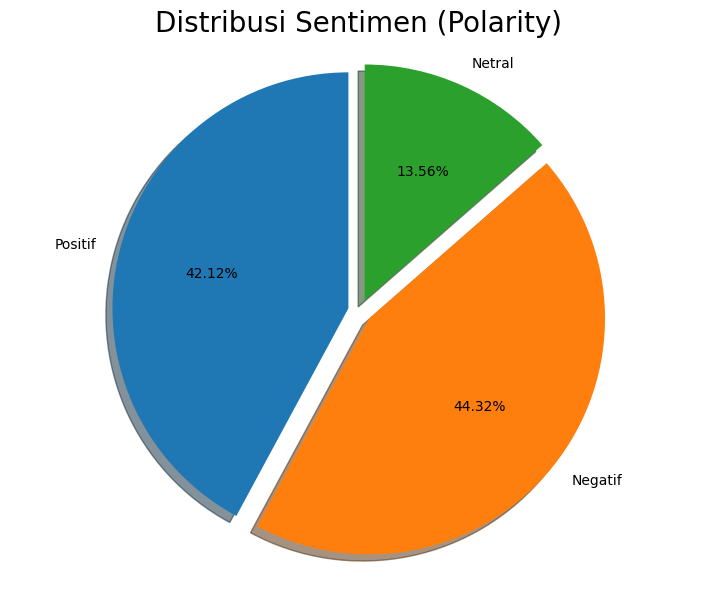

In [129]:
# Bikin semua huruf kecil dan hilangkan spasi ekstra
df_lab['polarity'] = df_lab['polarity'].str.lower().str.strip()

# Hitung frekuensi nilai
counts = df_lab['polarity'].value_counts()
print(counts)

# Ambil nilai untuk pie chart
labels = ['Positif', 'Negatif', 'Netral']
sizes = [counts.get('positive', 0), counts.get('negative', 0), counts.get('neutral', 0)]
print(sizes)

# Bikin pie chart jika ada data
if sum(sizes) > 0:
    explode = (0.05, 0.05, 0.05)
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.pie(
        x=sizes,
        explode=explode,
        labels=labels,
        autopct='%1.2f%%',
        shadow=True,
        startangle=90
    )
    ax.axis('equal')
    plt.title("Distribusi Sentimen (Polarity)", size=20)
    plt.show()
else:
    print("Tidak ada data yang bisa divisualisasikan.")

**Note**:
- Dari sini dapat dilihat persentase dari masing-masing label terhadap seluruh datasetnya dengan positif dan negatif cukup seimbang.

In [130]:
df_final = df_lab.copy()

# **5. Train Model with Different Schema**

## **5.1 Schema 1: Random Forest, TF-IDF, 80/20 Split**

In [144]:
X = df_final['text_akhir']
y = df_final['polarity']

In [145]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=3,
    max_df=0.8,
    ngram_range=(1, 2)
)
X_tfidf = tfidf.fit_transform(X)

In [146]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,abal,abis,abis ganti,abis pulsa,abis rb,abis update,abisin,acara,accord,account,...,yak,yamohon,yapadahal,yasaya,yh,yng,youtube,youtube lancar,yth,zaman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Menampilkan rasio data latih dan uji
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

total_data = len(y)
print("Rasio data latih: {:.2f}%".format((len(y_train) / total_data) * 100))
print("Rasio data uji: {:.2f}%".format((len(y_test) / total_data) * 100))

Jumlah data latih: 70567
Jumlah data uji: 17642
Rasio data latih: 80.00%
Rasio data uji: 20.00%


In [148]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Prediksi
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

# Evaluasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Output
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9985120523757564
Random Forest - accuracy_test: 0.8696292937308695


## **5.2 Schema 2: Naive Bayes, TF-IDF, 70/30 Split**

In [149]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Menampilkan rasio data latih dan uji
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

total_data = len(y)
print("Rasio data latih: {:.2f}%".format((len(y_train) / total_data) * 100))
print("Rasio data uji: {:.2f}%".format((len(y_test) / total_data) * 100))

Jumlah data latih: 61746
Jumlah data uji: 26463
Rasio data latih: 70.00%
Rasio data uji: 30.00%


In [150]:
nb_model = MultinomialNB(alpha=1.0, fit_prior=True)

# Fit model pada data pelatihan
nb_model.fit(X_train.toarray(), y_train)

# Prediksi
y_pred_train_nb = nb_model.predict(X_train.toarray())
y_pred_test_nb = nb_model.predict(X_test.toarray())

# Evaluasi
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)

# Tampilkan hasil
print('Naive Bayes - Accuracy Train:', accuracy_train_nb)
print('Naive Bayes - Accuracy Test:', accuracy_test_nb)

Naive Bayes - Accuracy Train: 0.7621870242606809
Naive Bayes - Accuracy Test: 0.7431886029550694


## **5.3 Schema 3: Logistic Regression, TF-IDF, 75/25**

In [151]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

# Menampilkan rasio data latih dan uji
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

total_data = len(y)
print("Rasio data latih: {:.2f}%".format((len(y_train) / total_data) * 100))
print("Rasio data uji: {:.2f}%".format((len(y_test) / total_data) * 100))

Jumlah data latih: 66156
Jumlah data uji: 22053
Rasio data latih: 75.00%
Rasio data uji: 25.00%


In [162]:
# Buat model Logistic Regression langsung dengan parameter default atau yang kamu tentukan
logreg_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='lbfgs', random_state=42)

# Fit model ke data pelatihan
logreg_model.fit(X_train, y_train)

# Prediksi
y_pred_train_lr = logreg_model.predict(X_train)
y_pred_test_lr = logreg_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)

# Tampilkan hasil
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9416228308845759
Logistic Regression - accuracy_test: 0.9230490182741578


## **5.4 Best Model**

| Model               | Schema                                             | Akurasi Train         | Akurasi Test          |
|---------------------|----------------------------------------------------|-----------------------|-----------------------|
| Random Forest       | Schema 1: Random Forest, TF-IDF, 80/20 Split       | 0.9985                | 0.8696                |
| Naive Bayes         | Schema 2: Naive Bayes, TF-IDF, 70/30 Split         | 0.7622                | 0.7432                |
| Logistic Regression | Schema 3: Logistic Regression, TF-IDF, 75/25 Split | 0.9416                | 0.9230                |


**Note**:
- Dari hasil ini menunjukkan bahwa model logistic regression memiliki performa yang lebih stabil dengan akurasi train sebesar 94% dan akurasi test 92%. Sehingga model ini yang digunakan untuk uji data baru.

# **6. Model Prediction Sentiment**

In [163]:
def prediksi_sentimen_kalimat(kalimat, tfidf, model):
    # Melakukan preprocessing pada kalimat baru
    kalimat_cleaned = cleaningText(kalimat)
    kalimat_casefolded = casefoldingText(kalimat_cleaned)
    kalimat_slangfixed = fix_slangwords(kalimat_casefolded)
    kalimat_tokenized = tokenizingText(kalimat_slangfixed)
    kalimat_filtered = filteringText(kalimat_tokenized)
    kalimat_final = toSentence(kalimat_filtered)

    # Menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
    X_kalimat = tfidf.transform([kalimat_final])

    # Memperoleh prediksi sentimen kalimat baru
    prediksi = model.predict(X_kalimat)

    # Menampilkan hasil prediksi
    if prediksi[0] == 'negative':
        return "Sentimen kalimat baru adalah NEGATIF."
    elif prediksi[0] == 'positive':
        return "Sentimen kalimat baru adalah POSITIF."
    else:
        return "Sentimen kalimat baru adalah NETRAL."

## **6.1 Positive Case**

In [164]:
kalimat_baru = input("Masukkan kalimat baru: ")
hasil_prediksi = prediksi_sentimen_kalimat(kalimat_baru, tfidf, logreg_model)
print(hasil_prediksi)

Masukkan kalimat baru: Sudah oke banget sekarang ga ada bug lagi kalo transfer uang
Sentimen kalimat baru adalah POSITIF.


## **6.2 Negative Case**

In [165]:
kalimat_baru = input("Masukkan kalimat baru: ")
hasil_prediksi = prediksi_sentimen_kalimat(kalimat_baru, tfidf, logreg_model)
print(hasil_prediksi)

Masukkan kalimat baru: Haduh saya kok ga bisa transfer jadi rugi gini uang hilang, tidak rekomended dah
Sentimen kalimat baru adalah NEGATIF.


## **6.3 Neutral Case**

In [166]:
kalimat_baru = input("Masukkan kalimat baru: ")
hasil_prediksi = prediksi_sentimen_kalimat(kalimat_baru, tfidf, logreg_model)
print(hasil_prediksi)

Masukkan kalimat baru: Cukup baik untuk sekarang
Sentimen kalimat baru adalah NETRAL.
